## **Model Prototyping**

This notebook builds and evaluates initial text classification models  
to detect spoiler vs non-spoiler reviews.

Baseline models tested:
- Multinomial Naive Bayes
- Logistic Regression


In [2]:
import nltk
import re
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score, f1_score
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import precision_recall_fscore_support
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
import os, torch
from dataclasses import dataclass
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from transformers import (BertTokenizerFast, BertForSequenceClassification,
                          DataCollatorWithPadding, get_linear_schedule_with_warmup)
from transformers import TrainingArguments, Trainer
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import joblib

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/akshit-
[nltk_data]     mac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/akshit-
[nltk_data]     mac/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/akshit-
[nltk_data]     mac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_feather("../data/preprocessed_reviews.feather")

### Adding Features
- `has_spoiler_tag`
- `full_text`

In [3]:
df["full_text"] = df["original_review_summary"] + " " + df["original_review_text"]
df["has_spoiler_tag"] = df["review_text"].apply(lambda x : "spoiler" in x)

### Splitting the data for training and testing

In [4]:
X = df[["full_text", "has_spoiler_tag", "review_text_ner"]]
y = df["is_spoiler"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_text = X_train["full_text"]
X_test_text = X_test["full_text"]
y_test = y_test.astype(str)

In [5]:
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])
print("Spoiler ratio (train):", y_train.value_counts(normalize=True))

Training samples: 459130
Testing samples: 114783
Spoiler ratio (train): is_spoiler
False    0.737027
True     0.262973
Name: proportion, dtype: float64


In [6]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    return " ".join(lemmatizer.lemmatize(w) for w in text.split())

X_train_clean_text = [clean_text(t) for t in X_train_text]
X_test_clean_text = [clean_text(t) for t in X_test_text]

### Vectorizing the `full_text` column

In [7]:
tfidf_full = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=3,
    max_df=0.8,
    sublinear_tf=True,
    stop_words='english'
)

X_train_tfidf = tfidf_full.fit_transform(X_train_clean_text)
X_test_tfidf = tfidf_full.transform(X_test_clean_text)

In [8]:
keywords = [
    "plot twist", "ending", "spoiler", "die", "surprise", "reveal", "betrayal",
    "twist", "kill", "death", "betray",
    "secret", "hidden truth", "big reveal", "unexpected", "shocking", "truth come out",
    "turn out", "actually", "real identity", "mask off", "double life", "deception",
    "disguise", "undercover", "false", "pretend", "plot reveal", "confession",
    "murder", "die in the end", "sacrifice", "fatal", "tragic end",
    "last scene", "final moment", "shot", "poison", "accident", "suicide",
    "dead", "death scene", "funeral", "grave",
    "turn against", "double cross", "traitor", "backstab", "deceive", "lie",
    "set up", "frame", "sell out", "enemy", "betrayal arc",
    "finale", "ending explain", "last episode", "climax", "final battle",
    "resolution", "conclusion", "credit scene", "after credit", "final twist",
    "mind blowing", "psychological", "hallucination", "dream", "illusion", "impostor",
    "gaslight", "paradox", "memory loss", "not real", "imagine", "alternate reality",
    "simulation", "hidden motive", "true story", "cover up", "reveal all", "plot uncovered",
    "secret revealed", "truth revealed", "twist ending", "unexpected ending",
    "major twist", "final reveal", "plot expose", "truth exposed",
    "identity reveal", "mask reveal", "real face", "truth behind", "dark secret",
    "hidden agenda", "big secret", "truth uncovered", "plot leak", "spoiler alert",
    "plot summary", "hidden clue", "truth discovered", "unmask", "truth behind the scenes",
    "ending reveal", "real story", "real meaning", "twist plot", "deceptive plot",
    "it was all a dream", "everything was fake", "alternate timeline", "fake death",
    "he never existed", "she never existed", "was alive", "alive after all",
    "they faked it", "time travel", "loop", "flashback", "false memory",
    "misdirection", "unreliable narrator", "true villain", "unexpected killer",
    "it was him", "it was her", "plot uncovered", "truth revealed",
    "the big twist", "turn of events", "revealed later", "flashforward",
    "time skip", "he returns", "she returns", "back from dead"
]

In [12]:
lemmatized_keywords = set([clean_text(k) for k in keywords])

In [13]:
tfidf_kw = TfidfVectorizer(
    vocabulary=lemmatized_keywords,
    ngram_range=(1, 3),
    lowercase=True
)
X_train_kw = tfidf_kw.fit_transform(X_train_clean_text)
X_test_kw = tfidf_kw.transform(X_test_clean_text)

### Putting everything together

In [14]:
X_train_numeric = X_train[["has_spoiler_tag"]].copy()
X_train_numeric["has_spoiler_tag"] = X_train_numeric["has_spoiler_tag"].astype(int)

X_test_numeric = X_test[["has_spoiler_tag"]].copy()
X_test_numeric["has_spoiler_tag"] = X_test_numeric["has_spoiler_tag"].astype(int)

In [16]:
X_train_combined = hstack([
    X_train_tfidf,
    X_train_kw,
    csr_matrix(X_train_numeric.values)
])

X_test_combined = hstack([
    X_test_tfidf,
    X_test_kw,
    csr_matrix(X_test_numeric.values)
])

## **Training with Naive Bayes**

In [17]:
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='f1')
grid.fit(X_train_combined, y_train)
print(grid.best_params_)

{'alpha': 0.01}


In [18]:
nb = MultinomialNB(alpha=grid.best_params_['alpha'])
nb.fit(X_train_combined, y_train)
nb_probs = nb.predict_proba(X_test_combined)[:, 1]

In [19]:
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred = (nb_probs >= t).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_test.map({'False':0,'True':1}), y_pred, average='binary', zero_division=np.nan)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1-Score: {best_f1:.4f}")


Best Threshold: 0.25
Best F1-Score: 0.5293


              precision    recall  f1-score   support

       False       0.85      0.73      0.79     84598
        True       0.46      0.63      0.53     30185

    accuracy                           0.70    114783
   macro avg       0.65      0.68      0.66    114783
weighted avg       0.74      0.70      0.72    114783



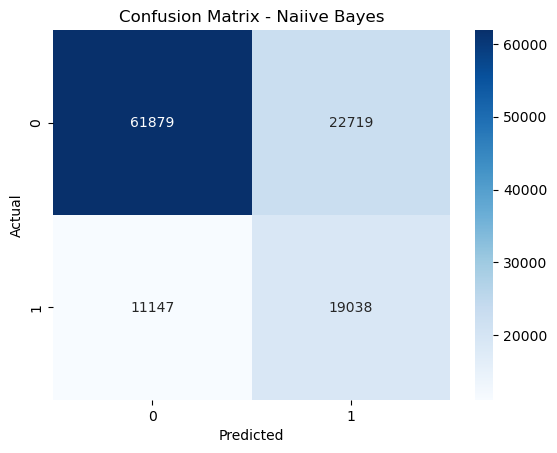

In [20]:
y_pred = np.where(nb_probs > best_threshold, 'True', 'False')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naiive Bayes")
plt.show()

In [21]:
precision_nb, recall_nb, f1_nb, _ = precision_recall_fscore_support(
    y_test.map({'False': 0, 'True': 1}),
    (y_pred == 'True').astype(int),
    average='binary',
    zero_division=np.nan
)
accuracy_nb = accuracy_score(y_test, y_pred)
macro_f1_nb = f1_score(y_test, y_pred, average='macro')

## **Training with Logistic Regression**

In [22]:
lr = LogisticRegression(
    max_iter=100,
    class_weight='balanced',
    solver='saga',
    n_jobs=-1
)
lr.fit(X_train_combined, y_train)
lr_probs = lr.predict_proba(X_test_combined)[:, 1]

In [ ]:
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred = (lr_probs >= t).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_test.map({'False':0,'True':1}), y_pred, average='binary', zero_division=np.nan)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1-Score: {best_f1:.4f}")

Best Threshold: 0.51
Best F1-Score: 0.5599


              precision    recall  f1-score   support

       False       0.86      0.76      0.81     84598
        True       0.49      0.65      0.56     30185

    accuracy                           0.73    114783
   macro avg       0.68      0.71      0.68    114783
weighted avg       0.76      0.73      0.74    114783



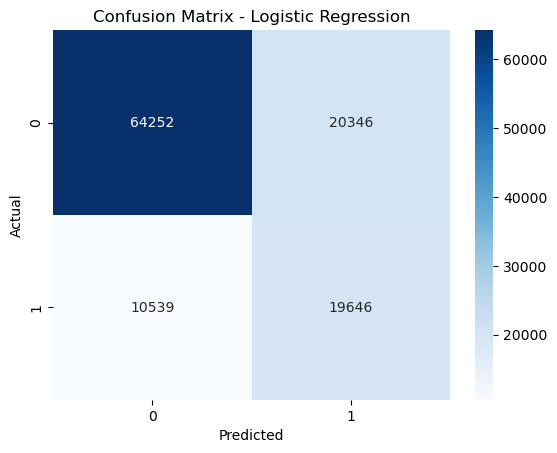

In [24]:
y_pred = np.where(lr_probs > best_threshold, 'True', 'False')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [25]:
precision_lr, recall_lr, f1_lr, _ = precision_recall_fscore_support(
    y_test.map({'False': 0, 'True': 1}),
    (y_pred == 'True').astype(int),
    average='binary',
    zero_division=np.nan
)
accuracy_lr = accuracy_score(y_test, y_pred)
macro_f1_lr = f1_score(y_test, y_pred, average='macro')

### **Comparing both the results**

In [26]:
results = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression'],
    'Precision (Spoiler)': [round(precision_nb, 2), round(precision_lr,2)],
    'Recall (Spoiler)': [round(recall_nb,2), round(recall_lr,2)],
    'F1 (Spoiler)': [round(f1_nb,2), round(f1_lr,2)],
    'Accuracy': [round(accuracy_nb,2), round(accuracy_lr,2)],
    'Macro F1': [round(macro_f1_nb,2), round(macro_f1_lr,2)]
})

results

,Model,Precision (Spoiler),Recall (Spoiler),F1 (Spoiler),Accuracy,Macro F1
0,Naive Bayes,0.46,0.63,0.53,0.70,0.66
1,Logistic Regression,0.49,0.65,0.56,0.73,0.68


## **BERT**

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

@dataclass
class BERTConfig:
    model_name: str = "bert-base-uncased"
    max_length: int = 256
    train_bs: int = 32
    eval_bs: int = 64
    lr: float = 2e-5
    weight_decay: float = 0.01
    epochs: int = 8
    warmup_ratio: float = 0.1
    gradient_accumulation_steps: int = 2
    fp16: bool = True
    num_workers: int = 0  # Set to 0 to avoid forking issues
    gradient_checkpointing: bool = True
    outdir: str = "../models/bert"
    max_grad_norm: float = 1.0

cfg = BERTConfig()
os.makedirs(cfg.outdir, exist_ok=True)

print("=" * 47)
print("BERT TRAINING CONFIGURATION")
print("=" * 47)
print(f"Model: {cfg.model_name}")
print(f"Max length: {cfg.max_length}")
print(f"Train batch size: {cfg.train_bs}")
print(f"Effective batch size: {cfg.train_bs * cfg.gradient_accumulation_steps}")
print(f"Eval batch size: {cfg.eval_bs}")
print(f"Learning rate: {cfg.lr}")
print(f"Weight decay: {cfg.weight_decay}")
print(f"Epochs: {cfg.epochs}")
print(f"Warmup ratio: {cfg.warmup_ratio}")
print(f"Mixed precision: {cfg.fp16}")
print(f"Gradient checkpointing: {cfg.gradient_checkpointing}")
print("=" * 47 + "\n")

BERT TRAINING CONFIGURATION
Model: bert-base-uncased
Max length: 256
Train batch size: 32
Effective batch size: 64
Eval batch size: 64
Learning rate: 2e-05
Weight decay: 0.01
Epochs: 8
Warmup ratio: 0.1
Mixed precision: True
Gradient checkpointing: True



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    torch.cuda.empty_cache()
else:
    print("TRAINING ON CPU! CHANGE AKSHIT CHANGE!!!!")

print("DATA HAS BEEN PLANTED! 40 seconds till-")

Using device: cpu
TRAINING ON CPU! CHANGE AKSHIT CHANGE!!!!
DATA HAS BEEN PLANTED! 40 seconds till-


In [6]:
train_df = pd.read_csv("../data/bert/train.csv")
val_df = pd.read_csv("../data/bert/val.csv")
test_df = pd.read_csv("../data/bert/test.csv")

print(f"Train size: {len(train_df):,}")
print(f"Val size: {len(val_df):,}")
print(f"Test size: {len(test_df):,}")

Train size: 459,130
Val size: 57,391
Test size: 57,392


In [7]:
le_path = "../data/bert/label_encoder.joblib"
if os.path.exists(le_path):
    le_spoiler = joblib.load(le_path)
    print("Label encoder loaded")
else:
    print("Creating label encoder...")
    all_labels = pd.concat([train_df["label"], val_df["label"], test_df["label"]])
    le_spoiler = LabelEncoder().fit(all_labels)
    joblib.dump(le_spoiler, le_path)
    print("Label encoder created and saved")

print(f"\nNumber of classes: {len(le_spoiler.classes_)}")
print(f"Classes: {le_spoiler.classes_}")
print(f"\nClass distribution in training set:")
print(train_df["label"].value_counts())
print(f"\nClass balance:")
print(train_df["label"].value_counts(normalize=True))

Label encoder loaded

Number of classes: 2
Classes: [False  True]

Class distribution in training set:
label
0    338391
1    120739
Name: count, dtype: int64

Class balance:
label
0    0.737027
1    0.262973
Name: proportion, dtype: float64


In [8]:
class SpoilerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = [str(t) for t in texts]
        self.labels = labels.astype(int).tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )
        
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

print("The datasets are ready to be served!")


The datasets are ready to be served!


In [9]:
tokenizer = BertTokenizerFast.from_pretrained(cfg.model_name)
print(f"Tokenizer loaded: {cfg.model_name}")

Tokenizer loaded: bert-base-uncased


In [10]:
train_ds = SpoilerDataset(train_df["text"], train_df["label"], tokenizer, cfg.max_length)
val_ds = SpoilerDataset(val_df["text"], val_df["label"], tokenizer, cfg.max_length)
test_ds = SpoilerDataset(test_df["text"], test_df["label"], tokenizer, cfg.max_length)

print(f"Train dataset: {len(train_ds):,} samples")
print(f"Val dataset: {len(val_ds):,} samples")
print(f"Test dataset: {len(test_ds):,} samples")

Train dataset: 459,130 samples
Val dataset: 57,391 samples
Test dataset: 57,392 samples


In [11]:
train_loader = DataLoader(
    train_ds,
    batch_size=cfg.train_bs,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_ds,
    batch_size=cfg.eval_bs,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_ds,
    batch_size=cfg.eval_bs,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nTrain batches: {len(train_loader):,}")
print(f"Val batches: {len(val_loader):,}")
print(f"Test batches: {len(test_loader):,}")


Train batches: 14,348
Val batches: 897
Test batches: 897


In [12]:
num_labels = len(le_spoiler.classes_)
model = BertForSequenceClassification.from_pretrained(
    cfg.model_name,
    num_labels=num_labels
).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
if cfg.gradient_checkpointing:
    model.gradient_checkpointing_enable()
    print("Gradient checkpointing enabled")

Gradient checkpointing enabled


In [14]:
cls_counts = train_df["label"].value_counts().sort_index().values
cls_weights = torch.tensor(
    cls_counts.sum() / (num_labels * cls_counts),
    dtype=torch.float,
    device=device
)

print(f"Model loaded with {num_labels} classes")
print(f"Class weights: {cls_weights.cpu().numpy()}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=cfg.lr,
    weight_decay=cfg.weight_decay
)

# Scheduler
total_steps = (len(train_loader) // cfg.gradient_accumulation_steps) * cfg.epochs
num_warmup = int(cfg.warmup_ratio * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup,
    num_training_steps=total_steps
)

Model loaded with 2 classes
Class weights: [0.6784016 1.9013326]
Total parameters: 109,483,778
Trainable parameters: 109,483,778


In [16]:
criterion = torch.nn.CrossEntropyLoss(weight=cls_weights)

# Gradient scaler for mixed precision
scaler = torch.amp.GradScaler('cuda',enabled=cfg.fp16)

print(f"Optimizer: AdamW (lr={cfg.lr}, weight_decay={cfg.weight_decay})")
print(f"Scheduler: Linear with warmup")
print(f"  Total steps: {total_steps:,}")
print(f"  Warmup steps: {num_warmup:,}")
print(f"Loss: CrossEntropyLoss with class weights")
print(f"Mixed precision: {cfg.fp16}")

Optimizer: AdamW (lr=2e-05, weight_decay=0.01)
Scheduler: Linear with warmup
  Total steps: 57,392
  Warmup steps: 5,739
Loss: CrossEntropyLoss with class weights
Mixed precision: True


/var/folders/40/y23pyn757t7_mmd6zxqx59240000gn/T/ipykernel_24833/593082747.py:4: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  scaler = torch.amp.GradScaler('cuda',enabled=cfg.fp16)


In [17]:
def train_epoch(epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    optimizer.zero_grad()
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{cfg.epochs}")
    
    for step, batch in enumerate(pbar):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Mixed precision forward pass
        with torch.amp.autocast('cuda', enabled=cfg.fp16):
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            loss = criterion(outputs.logits, batch["labels"])
            loss = loss / cfg.gradient_accumulation_steps
        
        # Backward pass
        scaler.scale(loss).backward()
        
        # Update metrics
        total_loss += loss.item() * cfg.gradient_accumulation_steps
        with torch.no_grad():
            preds = outputs.logits.argmax(dim=1)
            correct += (preds == batch["labels"]).sum().item()
            total += batch["labels"].size(0)
        
        # Gradient accumulation step
        if (step + 1) % cfg.gradient_accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item() * cfg.gradient_accumulation_steps:.4f}',
            'acc': f'{correct / total:.4f}',
            'lr': f'{scheduler.get_last_lr()[0]:.2e}'
        })
    
    return total_loss / len(train_loader), correct / total

In [19]:
@torch.no_grad()
def evaluate(loader, desc="Eval"):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    pbar = tqdm(loader, desc=desc)
    
    for batch in pbar:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        with torch.amp.autocast('cuda', enabled=cfg.fp16):
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"]
            )
        
        total_loss += outputs.loss.item() * batch["labels"].size(0)
        preds = outputs.logits.argmax(dim=1)
        
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(batch["labels"].cpu().tolist())
        
        pbar.set_postfix({'loss': f'{outputs.loss.item():.4f}'})
    
    avg_loss = total_loss / len(all_labels)
    accuracy = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    
    return avg_loss, accuracy, f1_macro, (all_labels, all_preds)

In [ ]:
train_losses, val_losses = [], []
train_accs, val_accs, val_f1s = [], []
best_val_f1 = 0
start_time = time.time()

for epoch in range(1, cfg.epochs + 1):
    epoch_start = time.time()
    
    print(f"\n{'=' * 70}")
    print(f"Epoch {epoch}/{cfg.epochs}")
    print('=' * 70)
    
    # Train
    train_loss, train_acc = train_epoch(epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc, val_f1, _ = evaluate(val_loader, desc="Validation")
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)
    
    epoch_time = time.time() - epoch_start
    
    # Print results
    print(f"\nEpoch {epoch} Results:")
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
    print(f"  Time: {epoch_time / 60:.2f} minutes")
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_path = os.path.join(cfg.outdir, "best_model")
        os.makedirs(best_model_path, exist_ok=True)
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        print(f"  ✓ New best model saved! (F1: {best_val_f1:.4f})")
    
    # Save checkpoint every 2 epochs
    if epoch % 2 == 0:
        checkpoint_path = os.path.join(cfg.outdir, f"checkpoint_epoch_{epoch}")
        os.makedirs(checkpoint_path, exist_ok=True)
        model.save_pretrained(checkpoint_path)
        print(f"  ✓ Checkpoint saved at epoch {epoch}")
    
    # Clear cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

total_time = time.time() - start_time


print(f"Total time: {total_time / 3600:.2f} hours ({total_time / 60:.2f} minutes)")
print(f"Average time per epoch: {total_time / cfg.epochs / 60:.2f} minutes")
print(f"Best validation F1: {best_val_f1:.4f}")

In [ ]:
best_model = BertForSequenceClassification.from_pretrained(
    os.path.join(cfg.outdir, "best_model")
).to(device)

model = best_model
test_loss, test_acc, test_f1, (test_labels, test_preds) = evaluate(
    test_loader, desc="Test"
)

print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  F1 (macro): {test_f1:.4f}")

print("\nClassification Report:")
print(classification_report(
    test_labels, 
    test_preds, 
    target_names=le_spoiler.classes_,
    digits=4
))

In [ ]:
results = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accs': train_accs,
    'val_accs': val_accs,
    'val_f1s': val_f1s,
    'test_loss': test_loss,
    'test_acc': test_acc,
    'test_f1': test_f1,
    'best_val_f1': best_val_f1
}

import json
with open(os.path.join(cfg.outdir, "training_results.json"), "w") as f:
    json.dump(results, f, indent=2)

print(f"\n✓ Training results saved to {cfg.outdir}/training_results.json")